In [18]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from classification.datasets import Dataset
from xgboost import XGBClassifier
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [19]:
np.random.seed(0)

In [20]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [21]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [22]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

20

In [23]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
# print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
naudio_sum = sum(naudio.values())
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * naudio_sum, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")


Class names: ['chainsaw', 'fire', 'fireworks', 'gun']
Shape of the feature matrix : (274, 400)
Number of labels : 274
Class 'chainsaw': 80 samples
Class 'fire': 79 samples
Class 'fireworks': 75 samples
Class 'gun': 40 samples


In [24]:
from tqdm import tqdm

### TO RUN
shift_pct_values = np.arange(0, 0.96, 0.24).tolist()  # List of shift_pct values
X_aug_list = []
y_aug_list = []

naudio_sum = sum(naudio.values())
for shift_pct in tqdm(shift_pct_values, desc="Processing shift_pct values"):
    myds_shifted = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=shift_pct)
    myds_shifted.mod_data_aug(["time_shift", "noise", "echo"])
    
    X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, featveclen))
    y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)
    
    for s in range(myds_shifted.data_aug_factor):
        offset = 0
        for class_idx, classname in enumerate(classnames):
            num_samples = naudio[classname]  # Number of samples for the current class
            for idx in range(num_samples):
                featvec = myds_shifted[classname, idx]
                X_aug_shifted[s * naudio_sum + offset + idx, :] = featvec
                y_aug_shifted[s * naudio_sum + offset + idx] = classname
            offset += num_samples  # Update the offset for the next class
    
    print(f"Shape of the feature matrix for shift_pct={shift_pct} : {X_aug_shifted.shape}")
    X_aug_list.append(X_aug_shifted)
    y_aug_list.append(y_aug_shifted)

X_aug = np.vstack(X_aug_list)
y_aug = np.concatenate(y_aug_list)


X_aug -= np.mean(X_aug, axis=0)
X_aug /= np.linalg.norm(X_aug, axis=0)

np.save(fm_dir + "feature_matrix_2D_GB.npy", X_aug)
np.save(fm_dir + "labels_2D_test_GB.npy", y_aug)

#########################################################################




X_aug = np.load(fm_dir + "feature_matrix_2D_GB.npy")
y_aug = np.load(fm_dir + "labels_2D_test_GB.npy", allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Processing shift_pct values:  25%|██▌       | 1/4 [00:04<00:14,  4.82s/it]

Shape of the feature matrix for shift_pct=0.0 : (1096, 400)


Processing shift_pct values:  50%|█████     | 2/4 [00:08<00:08,  4.22s/it]

Shape of the feature matrix for shift_pct=0.24 : (1096, 400)


Processing shift_pct values:  75%|███████▌  | 3/4 [00:11<00:03,  3.79s/it]

Shape of the feature matrix for shift_pct=0.48 : (1096, 400)


Processing shift_pct values: 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]

Shape of the feature matrix for shift_pct=0.72 : (1096, 400)
Shape of the feature matrix : (4384, 400)
Number of labels : 4384


Encoded labels: [3 2 1 ... 0 2 0]
Encoded labels: [1 2 0 ... 1 1 0]


/tmp/ipykernel_34673/2892526134.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'Chosen augmentations'])
/tmp/ipykernel_34673/2892526134.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)


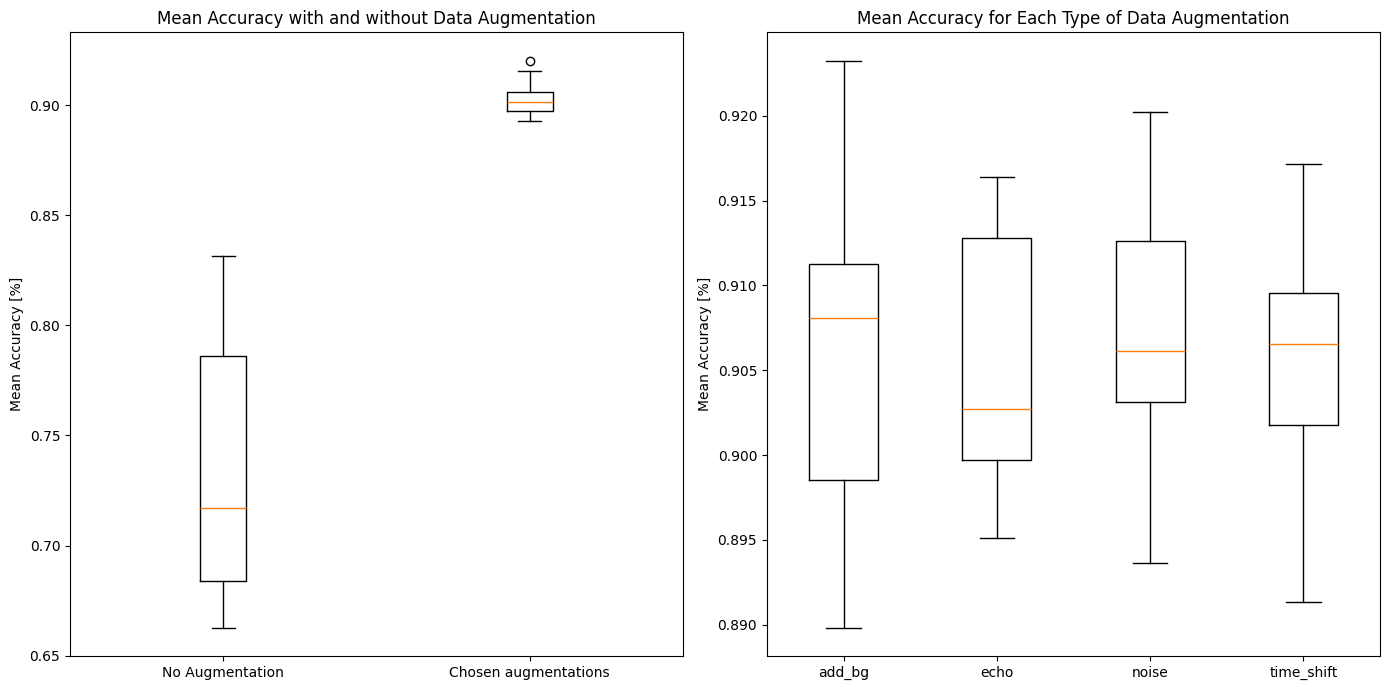

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import LabelEncoder



# Split the data
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42)

# Encode the string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Encoded labels: {y_train_encoded}")
print(f"Encoded labels: {y_test_encoded}")

if True:
    def evaluate_model(X_train, y_train, X_test, y_test):
        # Initialize the XGBoost classifier
        model_xgb = XGBClassifier(
            objective="multi:softmax",
            num_class=len(np.unique(y_train)),  # Number of unique classes
            n_estimators=50,
            max_depth=5,
            learning_rate=0.2,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            min_child_weight=3,
            random_state=42
        )
        model_xgb.fit(X_train, y_train)
        predictions = model_xgb.predict(X_test)
        return accuracy(y_test, predictions)

    # Number of evaluations to perform
    n_evaluations = 20
    X_no_aug,x_test_no_aug, y_no_aug,y_no_aug_test = train_test_split(X, y, test_size=0.3, stratify=y)
    # Evaluate without data augmentation
    accuracies_no_aug = []
    for _ in range(n_evaluations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_test_encoded = label_encoder.transform(y_test)
        accuracies_no_aug.append(evaluate_model(X_train, y_train_encoded, X_test, y_test_encoded))

    # Evaluate with all data augmentation
    X_aug_all = np.load(fm_dir + "feature_matrix_2D_GB.npy")
    y_aug_all = np.load(fm_dir + "labels_2D_test_GB.npy", allow_pickle=True)
    accuracies_all_aug = []
    for _ in range(n_evaluations):
        X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_aug_all, y_aug_all, test_size=0.3, stratify=y_aug_all)
        y_train_all_encoded = label_encoder.fit_transform(y_train_all)
        y_test_all_encoded = label_encoder.transform(y_test_all)
        accuracies_all_aug.append(evaluate_model(X_train_all, y_train_all_encoded, X_test_all, y_test_all_encoded))

    # Evaluate with individual data augmentations
    augmentations = ["add_bg", "echo", "noise", "time_shift"]
    accuracies_individual_aug = {aug: [] for aug in augmentations}

    for aug in augmentations:
        myds.mod_data_aug([aug])
        X_aug_individual = np.load(fm_dir + "feature_matrix_2D_GB.npy")
        y_aug_individual = np.load(fm_dir + "labels_2D_test_GB.npy", allow_pickle=True)
        for _ in range(n_evaluations):
            X_train_individual, X_test_individual, y_train_individual, y_test_individual = train_test_split(X_aug_individual, y_aug_individual, test_size=0.3, stratify=y_aug_individual)
            y_train_individual_encoded = label_encoder.fit_transform(y_train_individual)
            y_test_individual_encoded = label_encoder.transform(y_test_individual)
            accuracies_individual_aug[aug].append(evaluate_model(X_train_individual, y_train_individual_encoded, X_test_individual, y_test_individual_encoded))

    # Plot the results
    # Save the plots as a PDF
    with PdfPages('data_augmentation_results_xgb.pdf') as pdf:
        plt.figure(figsize=(14, 7))

        # Plot accuracy with and without data augmentation
        plt.subplot(1, 2, 1)
        plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'Chosen augmentations'])
        plt.ylabel('Mean Accuracy [%]')
        plt.title('Mean Accuracy with and without Data Augmentation')

        plt.subplot(1, 2, 2)
        plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
        plt.ylabel('Mean Accuracy [%]')
        plt.title('Mean Accuracy for Each Type of Data Augmentation')

        plt.tight_layout()
        pdf.savefig()  # Save the current figure into a pdf page
        plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd



if True:

    param_grid = {
        'n_estimators': [50],
        'max_depth': [5],
        'learning_rate': [0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5]
    }
    from sklearn.preprocessing import LabelEncoder

    # Encode the string labels into integers
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Initialize the XGBoost classifier
    xgb = XGBClassifier(
        objective="multi:softmax",
        num_class=len(label_encoder.classes_),  # Use the number of unique classes
        random_state=0
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit the grid search to the data
    grid_search.fit(X_train_normalized, y_train_encoded)

    # Get the best parameters and the best model
    best_params = grid_search.best_params_
    best_xgb = grid_search.best_estimator_

    print(f"Best parameters found: {best_params}")

    # Evaluate the best model on the test set
    y_pred_encoded = best_xgb.predict(X_test_normalized)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Decode predictions back to original labels
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy with best XGBoost: {accuracy * 100:.2f}%")

    # Save the best model
    filename_xgb_model = "best_xgb_model.pickle"
    pickle.dump(best_xgb, open(model_dir + filename_xgb_model, "wb"))
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        "Parameter Set": [str(params) for params in grid_search.cv_results_['params']],
        "Mean Test Accuracy": grid_search.cv_results_['mean_test_score'],
        "Std Test Accuracy": grid_search.cv_results_['std_test_score']
    })

    # Save the results to a CSV file
    results_csv_path = "classification/grid_search_results.csv"
    results_df.to_csv(results_csv_path, index=False)

    print(f"Grid search results saved to {results_csv_path}")

ValueError: Found input variables with inconsistent numbers of samples: [3068, 191]

<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

In [30]:
best_params = {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}
# Test set accuracy with best XGBoost: 91.03%
from sklearn.metrics import accuracy_score
# Initialize XGBoost classifier with the best parameters
best_xgc = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    objective="multi:softmax",
    num_class=len(classnames),
    random_state=42
)
X_aug = np.load(fm_dir + "feature_matrix_2D_GB.npy")
y_aug = np.load(fm_dir + "labels_2D_test_GB.npy", allow_pickle=True)
x_train_normalized, x_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# [4] Evaluate RF without PCA
n_splits = 5  # Number of cross-validation splits
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies_no_pca = []
for train_idx, val_idx in kf.split(X_train_normalized, y_train):
    # Train and evaluate the Random Forest model without PCA
    best_xgc.fit(X_train_normalized[train_idx], y_train[train_idx])
    y_pred = best_xgc.predict(X_test_normalized)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    accuracies_no_pca.append(accuracy)

mean_accuracy_no_pca = np.mean(accuracies_no_pca)
print(f"Mean Accuracy without PCA: {mean_accuracy_no_pca * 100:.2f}%")

# [5] Evaluate RF with PCA
pca_components = range(1, min(X_train_normalized.shape[1], 50))  # Test 1 to 20 components
mean_accuracies_with_pca = []

for n_components in pca_components:
    accuracies_with_pca = []
    pca = PCA(n_components=n_components, whiten=True)
    
    for train_idx, val_idx in kf.split(X_train_normalized, y_train):
        # Apply PCA
        
        X_train_pca = pca.fit_transform(X_train_normalized[train_idx])
        X_val_pca = pca.transform(X_train_normalized[val_idx])
        
        # Train and evaluate the Random Forest model
        best_xgc.fit(X_train_pca, y_train[train_idx])
        X_test_pca = pca.transform(X_test_normalized)
        y_pred = best_xgc.predict(X_test_pca)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        accuracies_with_pca.append(accuracy)
    
    # Compute the mean accuracy for the current number of PCA components
    mean_accuracy_with_pca = np.mean(accuracies_with_pca)
    mean_accuracies_with_pca.append(mean_accuracy_with_pca)
    print(f"PCA components: {n_components}, Mean Accuracy: {mean_accuracy_with_pca * 100:.2f}%")

# [6] Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pca_components, [acc * 100 for acc in mean_accuracies_with_pca], marker='o', label='With PCA')
plt.axhline(y=mean_accuracy_no_pca * 100, color='r', linestyle='--', label='Without PCA')
plt.xlabel('Number of PCA Components')
plt.xticks(np.arange(0, 50, 5))
plt.ylabel('Mean Accuracy (%)')
plt.title('Comparison of Random Forest with and without PCA')
plt.grid(True)
plt.legend()

from matplotlib.backends.backend_pdf import PdfPages
from xgboost import XGBClassifier
pdf_filename = "GB_with_vs_without_pca.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()
    plt.close()

print(f"Plot saved as {pdf_filename}")

Mean Accuracy without PCA: 88.91%
PCA components: 1, Mean Accuracy: 49.33%
PCA components: 2, Mean Accuracy: 56.35%
PCA components: 3, Mean Accuracy: 67.51%
PCA components: 4, Mean Accuracy: 74.76%
PCA components: 5, Mean Accuracy: 78.92%
PCA components: 6, Mean Accuracy: 79.22%
PCA components: 7, Mean Accuracy: 80.81%
PCA components: 8, Mean Accuracy: 82.99%
PCA components: 9, Mean Accuracy: 85.26%
PCA components: 10, Mean Accuracy: 88.16%
PCA components: 11, Mean Accuracy: 87.49%
PCA components: 12, Mean Accuracy: 88.18%
PCA components: 13, Mean Accuracy: 89.36%
PCA components: 14, Mean Accuracy: 89.95%
PCA components: 15, Mean Accuracy: 89.60%
PCA components: 16, Mean Accuracy: 89.67%
PCA components: 17, Mean Accuracy: 89.47%
PCA components: 18, Mean Accuracy: 89.92%
PCA components: 19, Mean Accuracy: 90.14%
PCA components: 20, Mean Accuracy: 90.20%
PCA components: 21, Mean Accuracy: 90.20%
PCA components: 22, Mean Accuracy: 89.98%
PCA components: 23, Mean Accuracy: 90.71%
PCA compo

Number of labels: (4384,)


Mean accuracy with Random Forest 5-Fold CV: 91.7%
Std deviation in accuracy with 5-Fold CV: 2.0%
Test set accuracy with Random Forest: 90.73%


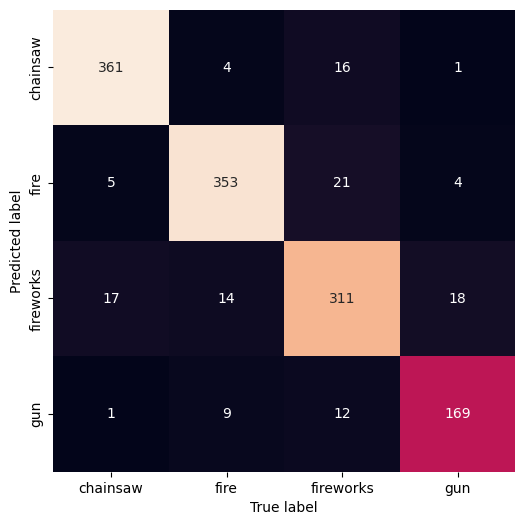

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pickle
from sklearn.decomposition import PCA

# [1] Create dataset of feature vectors and split it.
print(f"Number of labels: {y_aug.shape}")


X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42,stratify=y_aug)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

pca = PCA(n_components=29, whiten=True)

X_train = pca.fit_transform(X_train_normalized)
X_test = pca.transform(X_test_normalized)

filename_pca = "pca_29_GB_components.pickle"
pickle.dump(pca, open(model_dir + filename_pca, "wb"))

best_xgc = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    objective="multi:softmax",
    num_class=len(classnames),
    random_state=42
)


n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracies_rf = np.zeros((n_splits,))


for k, idx in enumerate(kf.split(X_train, y_train_encoded)):
    idx_learn, idx_val = idx
    best_xgc.fit(X_train[idx_learn], y_train_encoded[idx_learn])
    prediction_rf = best_xgc.predict(X_train[idx_val])
    accuracies_rf[k] = accuracy_score(y_train_encoded[idx_val], prediction_rf)
    

filename_model = "best_GB_model.pickle"
pickle.dump(best_xgc, open(model_dir + filename_model, "wb"))

print(f"Mean accuracy with Random Forest 5-Fold CV: {100 * accuracies_rf.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracies_rf.std():.1f}%")

y_pred = best_xgc.predict(X_test)
accuracy_rf = accuracy_score(y_test_encoded, y_pred)
print(f"Test set accuracy with Random Forest: {accuracy_rf * 100:.2f}%")

# Show the confusion matrix
show_confusion_matrix(y_pred, y_test_encoded, classnames)